# Hedging Project - Calibration

The aim of this code is to present : Delta, Delta-Gamma and Delta-Vega Hedging

In [55]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import datetime as dt

#### Data

In [56]:
path = r"/Users/thomascgd/Desktop/Z/Td Calibration/DonneesOptions.xlsx"
data = pd.read_excel(path,header=2,index_col='Date',parse_dates=True)
data.head()

,Prix action,Prix option strike 6,"Prix option strike 6,5"
Date,,,
2017-10-02,6.742,NaN,NaN
2017-10-03,6.955,NaN,NaN
2017-10-04,6.910,1.02096,0.59093
2017-10-05,7.006,1.09932,0.65885
2017-10-06,7.000,1.09306,0.65440


In [57]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 255 entries, 2017-10-04 to 2018-10-03
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Prix action             255 non-null    float64
 1   Prix option strike 6    255 non-null    float64
 2   Prix option strike 6,5  255 non-null    float64
dtypes: float64(3)
memory usage: 8.0 KB


#### Black-Scholes Formulas

In [58]:
def BS(S: float, T: float, sigma: float, K: float, r: float) -> float:
    '''
    Function to compute the price of an European call using the Black-Scholes-Merton formula
    '''
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

def BS_delta(S: float, T: float, sigma: float, K: float, r: float) -> float:
    '''
    Function to compute the delta
    '''
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

def BS_gamma(S: float, T: float, sigma: float, K: float, r: float) -> float:
    '''
    Function to compute the gamma
    '''
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return norm.pdf(d1) / (S * sigma * np.sqrt(T))

def BS_vega(S: float, T: float, sigma: float, K: float, r: float) -> float:
    '''
    Function to compute the vega
    '''
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    vega = S * np.sqrt(T) * norm.pdf(d1)
    return vega


## Delta Hedging with constant volatility

<Figure size 640x480 with 0 Axes>

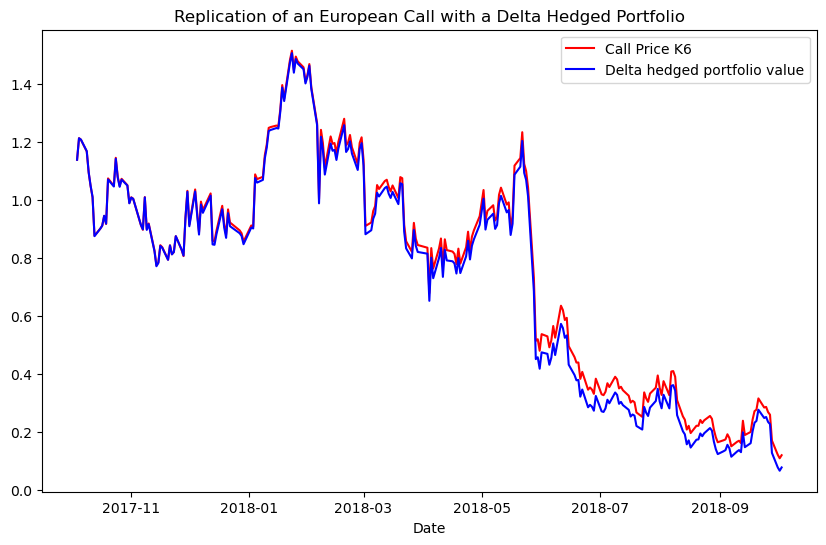

In [59]:
#Creation of the Delta-Hedged Portfolio
pft_delta_hedged=pd.DataFrame(index=data.index,columns=['Prix Call K6','Prix action','Quantite action','poche action','poche ZC','Valeur pft'])

#Initialisation
sigma=0.2 # Volatility | In this example the volatily is a constant. Below we will find the implied volatility for each date and use them
K=6       # Strike
r=0       # Risk-Free rate
maturite = dt.datetime(2018,12,31)
nb_jours=maturite-pft_delta_hedged.index[0]
nombre_jours_par_an=365.25
Temps=nb_jours.days/nombre_jours_par_an

# First row of the dataframe
pft_delta_hedged.iloc[0]['Prix action']=data.iloc[0]['Prix action']
pft_delta_hedged.iloc[0]['Prix Call K6']=BS(pft_delta_hedged.iloc[0]['Prix action'],Temps,sigma,K,r)
pft_delta_hedged.iloc[0]['Quantite action']=BS_delta(pft_delta_hedged.iloc[0]['Prix action'],Temps,sigma,K,r)
pft_delta_hedged.iloc[0]['poche action']=pft_delta_hedged.iloc[0]['Quantite action']*pft_delta_hedged.iloc[0]['Prix action']
pft_delta_hedged.iloc[0]['Valeur pft']=pft_delta_hedged.iloc[0]['Prix Call K6']
pft_delta_hedged.iloc[0]['poche ZC']=pft_delta_hedged.iloc[0]['Valeur pft']-pft_delta_hedged.iloc[0]['poche action']

# Recurrence
for i in range(1,len(pft_delta_hedged.index)):
    nb_jours=maturite-pft_delta_hedged.index[i]
    Temps=nb_jours.days/nombre_jours_par_an
    pft_delta_hedged.iloc[i]['Prix action']=data.iloc[i]['Prix action']
    pft_delta_hedged.iloc[i]['Prix Call K6']=BS(pft_delta_hedged.iloc[i]['Prix action'],Temps,sigma,K,r)
    pft_delta_hedged.iloc[i]['Quantite action']=BS_delta(pft_delta_hedged.iloc[i]['Prix action'],Temps,sigma,K,r)
    pft_delta_hedged.iloc[i]['poche action']=pft_delta_hedged.iloc[i]['Quantite action']*pft_delta_hedged.iloc[i]['Prix action']
    pft_delta_hedged.iloc[i]['Valeur pft']=pft_delta_hedged.iloc[i-1]['Valeur pft'] + \
        pft_delta_hedged.iloc[i-1]['Quantite action'] * (pft_delta_hedged.iloc[i]['Prix action'] - pft_delta_hedged.iloc[i-1]['Prix action'])
    pft_delta_hedged.iloc[i]['poche ZC']=pft_delta_hedged.iloc[i]['Valeur pft']-pft_delta_hedged.iloc[i]['poche action']
    
plt.figure(1)
plt.figure(figsize=(10, 6)) 
plt.plot(pft_delta_hedged['Prix Call K6'],c='r')
plt.plot(pft_delta_hedged['Valeur pft'],c='b')
plt.xlabel('Date')
plt.legend(["Call Price K6","Delta hedged portfolio value"])
plt.title("Replication of an European Call with a Delta Hedged Portfolio")
plt.show()

## Delta-Gamma Hedging with constant volatility

<Figure size 640x480 with 0 Axes>

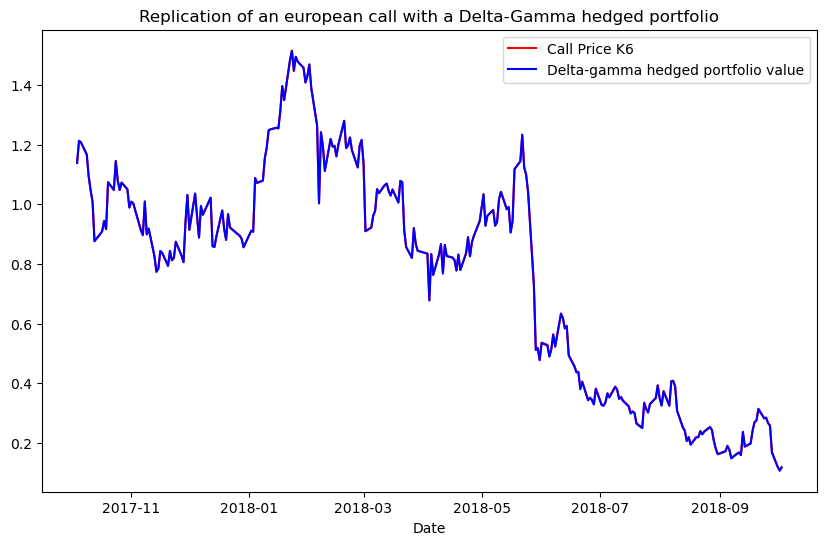

In [60]:
# Creation of the delta-gamma hedged Portfolio
pft_gamma_hedged=pd.DataFrame(index=data.index,columns=['Prix Call K6','Prix Call K6.5','Prix action','Quantite action','Quantite en Cbis','poche action','poche Cbis','poche ZC','Valeur pft'])

# Initialisation
sigma=0.2 # volatility of the underlying
K=6       # Strike
Kbis=6.5  # Strike bis
r=0       # Risk-free rate
maturite = dt.datetime(2018,12,31)
nb_jours=maturite-pft_gamma_hedged.index[0]
nombre_jours_par_an=365.25
Temps=nb_jours.days/nombre_jours_par_an

# First row of the dataframe
pft_gamma_hedged.iloc[0]['Prix action']=data.iloc[0]['Prix action']
pft_gamma_hedged.iloc[0]['Prix Call K6']=BS(pft_gamma_hedged.iloc[0]['Prix action'],Temps,sigma,K,r)
pft_gamma_hedged.iloc[0]['Prix Call K6.5']=BS(pft_gamma_hedged.iloc[0]['Prix action'],Temps,sigma,Kbis,r)
    
        #Delta and gamma calculation of an European call
delta=BS_delta(pft_gamma_hedged.iloc[0]['Prix action'],Temps,sigma,K,r)
delta_bis=BS_delta(pft_gamma_hedged.iloc[0]['Prix action'],Temps,sigma,Kbis,r)
gamma=BS_gamma(pft_gamma_hedged.iloc[0]['Prix action'],Temps,sigma,K,r)
gamma_bis=BS_gamma(pft_gamma_hedged.iloc[0]['Prix action'],Temps,sigma,Kbis,r)

pft_gamma_hedged.iloc[0]['Quantite action']=delta-(delta_bis*(gamma/gamma_bis))
pft_gamma_hedged.iloc[0]['Quantite en Cbis']=gamma/gamma_bis
pft_gamma_hedged.iloc[0]['poche action']=pft_gamma_hedged.iloc[0]['Quantite action']*pft_gamma_hedged.iloc[0]['Prix action']
pft_gamma_hedged.iloc[0]['poche Cbis']=pft_gamma_hedged.iloc[0]['Prix Call K6.5']*gamma/gamma_bis
pft_gamma_hedged.iloc[0]['Valeur pft']=pft_gamma_hedged.iloc[0]['Prix Call K6']
pft_gamma_hedged.iloc[0]['poche ZC']=pft_gamma_hedged.iloc[0]['Valeur pft']-pft_gamma_hedged.iloc[0]['poche action']-pft_gamma_hedged.iloc[0]['poche Cbis']

# Recurrence
for i in range(1,len(pft_gamma_hedged.index)):
    nb_jours=maturite-pft_gamma_hedged.index[i]
    Temps=nb_jours.days/nombre_jours_par_an
    pft_gamma_hedged.iloc[i]['Prix action']=data.iloc[i]['Prix action']
    pft_gamma_hedged.iloc[i]['Prix Call K6']=BS(pft_gamma_hedged.iloc[i]['Prix action'],Temps,sigma,K,r)
    pft_gamma_hedged.iloc[i]['Prix Call K6.5']=BS(pft_gamma_hedged.iloc[i]['Prix action'],Temps,sigma,Kbis,r)

        #Delta and gamma calculation of an European call
    delta=BS_delta(pft_gamma_hedged.iloc[i]['Prix action'],Temps,sigma,K,r)
    delta_bis=BS_delta(pft_gamma_hedged.iloc[i]['Prix action'],Temps,sigma,Kbis,r)
    gamma=BS_gamma(pft_gamma_hedged.iloc[i]['Prix action'],Temps,sigma,K,r)
    gamma_bis=BS_gamma(pft_gamma_hedged.iloc[i]['Prix action'],Temps,sigma,Kbis,r)

    pft_gamma_hedged.iloc[i]['Quantite action']=delta-(delta_bis*(gamma/gamma_bis))
    pft_gamma_hedged.iloc[i]['Quantite en Cbis']=gamma/gamma_bis
    pft_gamma_hedged.iloc[i]['poche action']=pft_gamma_hedged.iloc[i]['Quantite action']*pft_gamma_hedged.iloc[i]['Prix action']
    pft_gamma_hedged.iloc[i]['poche Cbis']=pft_gamma_hedged.iloc[i]['Prix Call K6.5']*gamma/gamma_bis
    pft_gamma_hedged.iloc[i]['Valeur pft']=pft_gamma_hedged.iloc[i-1]['Valeur pft']+\
        pft_gamma_hedged.iloc[i-1]['Quantite action']*(pft_gamma_hedged.iloc[i]['Prix action']-pft_gamma_hedged.iloc[i-1]['Prix action'])+\
        pft_gamma_hedged.iloc[i-1]['Quantite en Cbis']*(pft_gamma_hedged.iloc[i]['Prix Call K6.5']-pft_gamma_hedged.iloc[i-1]['Prix Call K6.5'])
    pft_gamma_hedged.iloc[i]['poche ZC']=pft_gamma_hedged.iloc[i]['Valeur pft']-pft_gamma_hedged.iloc[i]['poche action']-pft_gamma_hedged.iloc[i]['poche Cbis']

plt.figure(2)
plt.figure(figsize=(10, 6)) 
plt.plot(pft_gamma_hedged['Prix Call K6'],c='r')
plt.plot(pft_gamma_hedged['Valeur pft'],c='b')
plt.xlabel('Date')
plt.legend(["Call Price K6","Delta-gamma hedged portfolio value"])
plt.title("Replication of an european call with a Delta-Gamma hedged portfolio")
plt.show()

#### Average difference between the K6 Call Price and the value of the delta-gamma hedged portfolio

In [61]:
MAE = np.mean(np.abs(pft_gamma_hedged['Prix Call K6'] - pft_gamma_hedged['Valeur pft']))
print(f"the average difference is : {round(MAE,4)}")

the average difference is : 0.0006


## Functions to calculate the implied volatility

In [62]:
def newton_raphson(f,xzero,prix,S,T,K,r,eps=0.0001,niter_max=15,h=0.01) -> float:
    '''
    Newton-Raphson Algorithm
    '''
    x = xzero - f(xzero,prix,S,T,K,r)/((f(xzero+h,prix,S,T,K,r)-f(xzero,prix,S,T,K,r))/h)
    nb_iteration = 0
    while abs(f(x,prix,S,T,K,r))>eps and nb_iteration <niter_max:
        nb_iteration +=1
        x = x - f(x,prix,S,T,K,r)/((f(x+h,prix,S,T,K,r)-f(x,prix,S,T,K,r))/h)
    return x

def dichotomie(f,a,b,prix,S,T,K,r,eps=0.001,n=250) -> float:
    '''
    Dichotomie Function
    '''
    iteration=0
    if f(a,prix,S,T,K,r)*f(b,prix,S,T,K,r)>0 :
        return ValueError("Need to change the parameter a or b in order to have f(a)<0<f(b)")
    if f(a,prix,S,T,K,r)>f(b,prix,S,T,K,r):
        a,b=b,a
    while b-a>eps and iteration<=n:
        iteration+=1
        c=(a+b)/2
        if f(c,prix,S,T,K,r)>0:
            b=c
        else:
            a=c
    return (a+b)/2

#Calibration of the implied volatility
#The goal of this function is to see the difference between the price in the variable 'prix' and the price using the BS function
def fct_ecart(vol,price,S,T,K,r): # The variable 'price' correspond to the price of an European call
    return BS(S,T,vol,K,r)-price 


#### Tests on the functions

In [63]:
#Tests 
prix=4.237 # Price of the call option
S=10 # Price of the underlying
T=1  # Time to expiry in years
K=6  # Strike
r=0  # Risk-Free rate

print(f"Price of the European call to find : {prix}")

print("Test with the Newton-Raphson method")
vol_implicite_NR=newton_raphson(fct_ecart,0.2,prix,S,T,K,r)
print('Estimated Implied volatility : ',round(vol_implicite_NR,3))
print("Estimated European Call Price",round(BS(S,T,vol_implicite_NR,K,r),3)) 

print("\n")

print("Test with the Dichotomie method")
a=0.001 #starting point of the volatility
b=10
vol_implicite_D=dichotomie(fct_ecart,a,b,prix,S,T,K,r)
print('Estimated Implied volatility : ',round(vol_implicite_D,3))
print("Estimated European Call Price",round(BS(S,T,vol_implicite_D,K,r),3))

Price of the European call to find : 4.237
Test with the Newton-Raphson method
Estimated Implied volatility :  0.461
Estimated European Call Price 4.237


Test with the Dichotomie method
Estimated Implied volatility :  0.461
Estimated European Call Price 4.237


#### Representation of the price european call in function of the volatility

<Figure size 640x480 with 0 Axes>

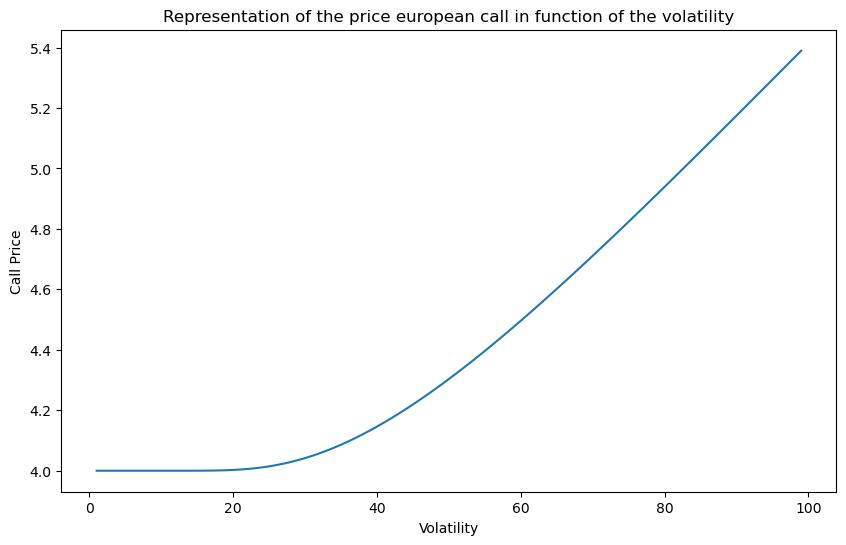

In [64]:
def iteration(n=100):
    vol = []
    prix = []
    for i in range(1,n):
        vol.append(i)
        prix.append(BS(S=10,T=1,sigma=i/100,K=6,r=0)) #vol en %
    plt.figure(11)
    plt.figure(figsize=(10, 6))
    plt.plot(vol,prix)
    plt.xlabel('Volatility')
    plt.ylabel('Call Price')
    plt.title("Representation of the price european call in function of the volatility")
    plt.show()

iteration()

## Computation of the implied volatily for the two options at each date

In [65]:
#Creation of the dataframe containing the prices and the implied volatilities of the options of strike 6 and 6.5
iv=pd.DataFrame(index=data.index,columns=['Prix action','Prix option strike 6','vol implicite option strike 6 Newton-Raphson','vol implicite option strike 6 Dichotomie','Prix option strike 6.5','vol implicite option strike 6.5 Newton-Raphson','vol implicite option strike 6.5 Dichotomie'])

#parameters
maturite = dt.datetime(2018,12,31) # Maturity of the option
nombre_jours_par_an=365.25 # Number of days in a year
K=6      #Strike
Kbis=6.5 #Strike bis
r=0      #Risk-free rate

for i in range(len(iv.index)):
    nb_jours=maturite-iv.index[i]
    Temps=nb_jours.days/nombre_jours_par_an
    iv.iloc[i]['Prix action']=data.iloc[i]['Prix action']
    iv.iloc[i]['Prix option strike 6']=data.iloc[i]['Prix option strike 6']
    iv.iloc[i]['vol implicite option strike 6 Newton-Raphson']=newton_raphson(fct_ecart,0.2,iv.iloc[i]['Prix option strike 6'],iv.iloc[i]['Prix action'],Temps,K,r)
    iv.iloc[i]['vol implicite option strike 6 Dichotomie']=dichotomie(fct_ecart,0.0001,10,iv.iloc[i]['Prix option strike 6'],iv.iloc[i]['Prix action'],Temps,K,r)
    iv.iloc[i]['Prix option strike 6.5']=data.iloc[i]['Prix option strike 6,5']
    iv.iloc[i]['vol implicite option strike 6.5 Newton-Raphson']=newton_raphson(fct_ecart,0.2,iv.iloc[i]['Prix option strike 6.5'],iv.iloc[i]['Prix action'],Temps,Kbis,r)
    iv.iloc[i]['vol implicite option strike 6.5 Dichotomie']=dichotomie(fct_ecart,0.0001,10,iv.iloc[i]['Prix option strike 6.5'],iv.iloc[i]['Prix action'],Temps,Kbis,r)
    
iv.head()

,Prix action,Prix option strike 6,vol implicite option strike 6 Newton-Raphson,vol implicite option strike 6 Dichotomie,Prix option strike 6.5,vol implicite option strike 6.5 Newton-Raphson,vol implicite option strike 6.5 Dichotomie
Date,,,,,,,
2017-10-04,6.91,1.02096,0.145913,0.145667,0.59093,0.117028,0.116981
2017-10-05,7.006,1.09932,0.144845,0.145057,0.65885,0.116606,0.116371
2017-10-06,7.0,1.09306,0.144367,0.144447,0.6544,0.116728,0.116981
2017-10-09,6.95,1.04813,0.143431,0.143226,0.61591,0.116356,0.116371
2017-10-10,6.856,0.96879,0.143012,0.143226,0.54811,0.115804,0.11576


## Plot of the implied volatilies of the two options

<Figure size 640x480 with 0 Axes>

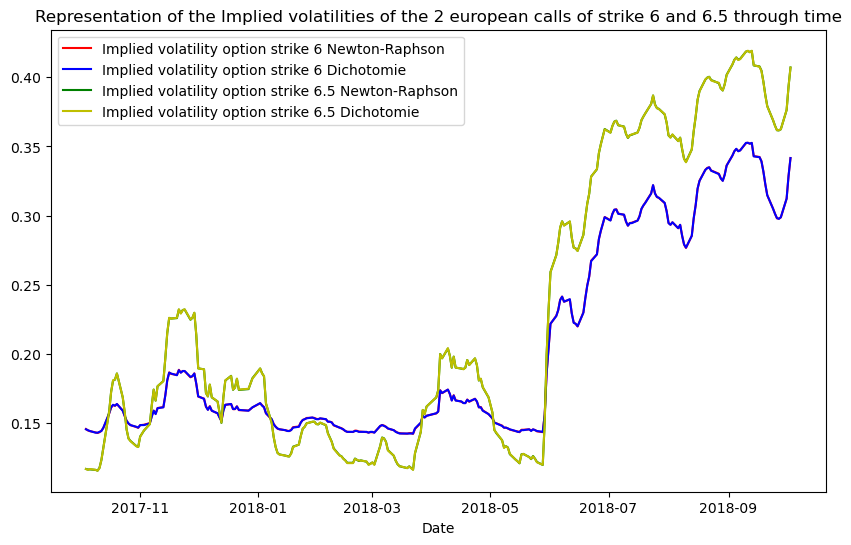

<Figure size 640x480 with 0 Axes>

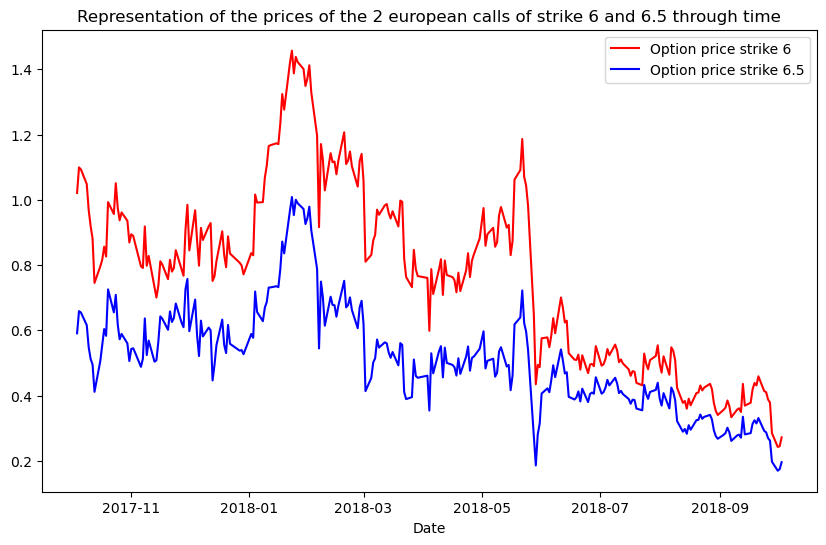

In [66]:
plt.figure(3)
plt.figure(figsize=(10, 6))
plt.plot(iv['vol implicite option strike 6 Newton-Raphson'],c='r')
plt.plot(iv['vol implicite option strike 6 Dichotomie'],c='b')
plt.plot(iv['vol implicite option strike 6.5 Newton-Raphson'],c='g')
plt.plot(iv['vol implicite option strike 6.5 Dichotomie'],c='y')
plt.xlabel('Date')
plt.legend(["Implied volatility option strike 6 Newton-Raphson","Implied volatility option strike 6 Dichotomie","Implied volatility option strike 6.5 Newton-Raphson","Implied volatility option strike 6.5 Dichotomie"])
plt.title("Representation of the Implied volatilities of the 2 european calls of strike 6 and 6.5 through time")
plt.show()

# 4 curves are on the graph, but we can only see two of them because the Dichotomie function and the Newton-Raphson function give the same results.

plt.figure(4)
plt.figure(figsize=(10, 6))
plt.plot(iv['Prix option strike 6'],c="r")
plt.plot(iv['Prix option strike 6.5'],c="b")
plt.xlabel('Date')
plt.legend(["Option price strike 6","Option price strike 6.5"])
plt.title("Representation of the prices of the 2 european calls of strike 6 and 6.5 through time")
plt.show()


## Delta Hedging with the implied volatilities

<Figure size 640x480 with 0 Axes>

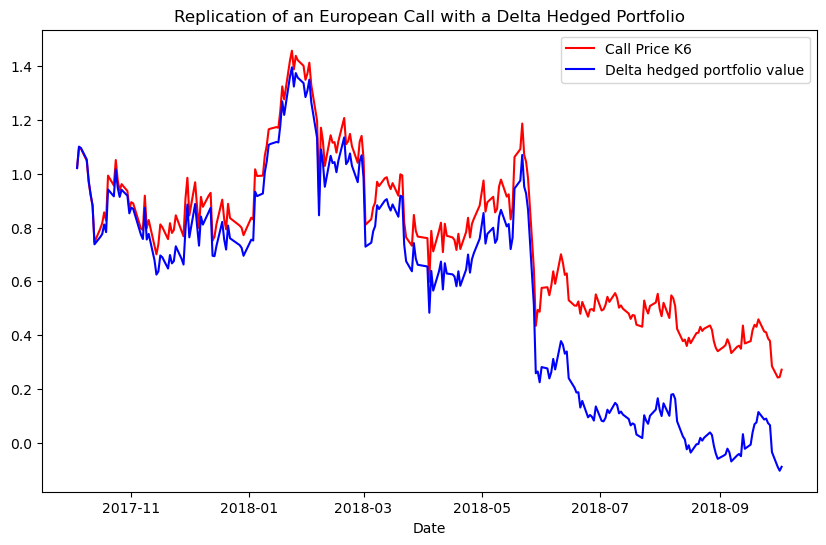

In [67]:
#Creation of the Delta Hedging portfolio bis
Delta_bis_df=pd.DataFrame(index=data.index,columns=['Prix Call K6','Prix action','Quantite action','poche action','poche ZC','Valeur pft'])

#Initialisation
K=6 #Strike
r=0 #Risk-free rate
maturite = dt.datetime(2018,12,31)
nb_jours=maturite-Delta_bis_df.index[0]
nombre_jours_par_an=365.25
Temps=nb_jours.days/nombre_jours_par_an

#First row of the dataframe
Delta_bis_df.iloc[0]['Prix action']=data.iloc[0]['Prix action']
Delta_bis_df.iloc[0]['Prix Call K6']=data.iloc[0]['Prix option strike 6']
Delta_bis_df.iloc[0]['Quantite action']=BS_delta(Delta_bis_df.iloc[0]['Prix action'],Temps,iv.iloc[0]['vol implicite option strike 6 Newton-Raphson'],K,r)
Delta_bis_df.iloc[0]['poche action']=Delta_bis_df.iloc[0]['Quantite action']*Delta_bis_df.iloc[0]['Prix action']
Delta_bis_df.iloc[0]['Valeur pft']=Delta_bis_df.iloc[0]['Prix Call K6']
Delta_bis_df.iloc[0]['poche ZC']=Delta_bis_df.iloc[0]['Valeur pft']-Delta_bis_df.iloc[0]['poche action']

#Recurrence
for i in range(1,len(Delta_bis_df.index)):
    nb_jours=maturite-Delta_bis_df.index[i]
    Temps=nb_jours.days/nombre_jours_par_an
    Delta_bis_df.iloc[i]['Prix action']=data.iloc[i]['Prix action']
    Delta_bis_df.iloc[i]['Prix Call K6']=data.iloc[i]['Prix option strike 6']
    Delta_bis_df.iloc[i]['Quantite action']=BS_delta(Delta_bis_df.iloc[i]['Prix action'],Temps,iv.iloc[i]['vol implicite option strike 6 Newton-Raphson'],K,r)
    Delta_bis_df.iloc[i]['poche action']=Delta_bis_df.iloc[i]['Quantite action']*Delta_bis_df.iloc[i]['Prix action']
    Delta_bis_df.iloc[i]['Valeur pft']=Delta_bis_df.iloc[i-1]['Valeur pft'] + \
        Delta_bis_df.iloc[i-1]['Quantite action'] * (Delta_bis_df.iloc[i]['Prix action'] - Delta_bis_df.iloc[i-1]['Prix action'])
    Delta_bis_df.iloc[i]['poche ZC']=Delta_bis_df.iloc[i]['Valeur pft']-Delta_bis_df.iloc[i]['poche action']
    
plt.figure(1)
plt.figure(figsize=(10, 6)) 
plt.plot(Delta_bis_df['Prix Call K6'],c='r')
plt.plot(Delta_bis_df['Valeur pft'],c='b')
plt.xlabel('Date')
plt.legend(["Call Price K6","Delta hedged portfolio value"])
plt.title("Replication of an European Call with a Delta Hedged Portfolio")
plt.show()

## Delta Gamma Hedging with the implied volatilities

<Figure size 640x480 with 0 Axes>

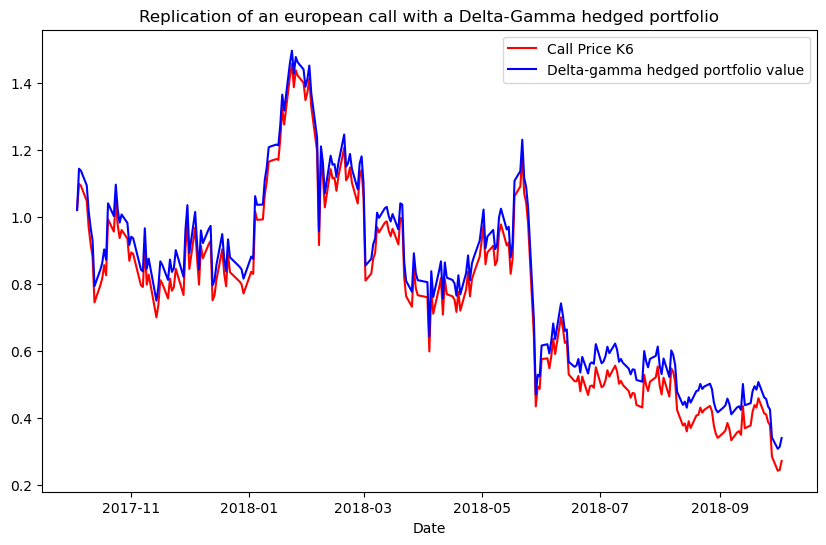

In [68]:
#Création du portefeuille delta-gamma hedged
Gamma_bis_df=pd.DataFrame(index=data.index,columns=['Prix Call K6','Prix Call K6.5','Prix action','Quantite action','Quantite en Cbis','poche action','poche Cbis','poche ZC','Valeur pft'])

#Initialisation
K=6
Kbis=6.5
r=0
maturite = dt.datetime(2018,12,31)
nb_jours=maturite-Gamma_bis_df.index[0]
nombre_jours_par_an=365.25
Temps=nb_jours.days/nombre_jours_par_an

#First row of the dataframe
Gamma_bis_df.iloc[0]['Prix action']=data.iloc[0]['Prix action']
Gamma_bis_df.iloc[0]['Prix Call K6']=BS(Gamma_bis_df.iloc[0]['Prix action'],Temps,iv.iloc[0]['vol implicite option strike 6 Newton-Raphson'],K,r)
Gamma_bis_df.iloc[0]['Prix Call K6.5']=BS(Gamma_bis_df.iloc[0]['Prix action'],Temps,iv.iloc[0]['vol implicite option strike 6.5 Newton-Raphson'],Kbis,r)
    
    #Calculation of the delta and gamma for each european call
delta=BS_delta(Gamma_bis_df.iloc[0]['Prix action'],Temps,iv.iloc[0]['vol implicite option strike 6 Newton-Raphson'],K,r)
delta_bis=BS_delta(Gamma_bis_df.iloc[0]['Prix action'],Temps,iv.iloc[0]['vol implicite option strike 6.5 Newton-Raphson'],Kbis,r)
gamma=BS_gamma(Gamma_bis_df.iloc[0]['Prix action'],Temps,iv.iloc[0]['vol implicite option strike 6 Newton-Raphson'],K,r)
gamma_bis=BS_gamma(Gamma_bis_df.iloc[0]['Prix action'],Temps,iv.iloc[0]['vol implicite option strike 6.5 Newton-Raphson'],Kbis,r)

Gamma_bis_df.iloc[0]['Quantite action']=delta-(delta_bis*(gamma/gamma_bis))
Gamma_bis_df.iloc[0]['Quantite en Cbis']=gamma/gamma_bis
Gamma_bis_df.iloc[0]['poche action']=Gamma_bis_df.iloc[0]['Quantite action']*Gamma_bis_df.iloc[0]['Prix action']
Gamma_bis_df.iloc[0]['poche Cbis']=Gamma_bis_df.iloc[0]['Prix Call K6.5']*gamma/gamma_bis
Gamma_bis_df.iloc[0]['Valeur pft']=Gamma_bis_df.iloc[0]['Prix Call K6']
Gamma_bis_df.iloc[0]['poche ZC']=Gamma_bis_df.iloc[0]['Valeur pft']-Gamma_bis_df.iloc[0]['poche action']-Gamma_bis_df.iloc[0]['poche Cbis']

#Recurrence
for i in range(1,len(Gamma_bis_df.index)):
    nb_jours=maturite-Gamma_bis_df.index[i]
    Temps=nb_jours.days/nombre_jours_par_an
    Gamma_bis_df.iloc[i]['Prix action']=data.iloc[i]['Prix action']
    Gamma_bis_df.iloc[i]['Prix Call K6']=BS(Gamma_bis_df.iloc[i]['Prix action'],Temps,iv.iloc[i]['vol implicite option strike 6 Newton-Raphson'],K,r)
    Gamma_bis_df.iloc[i]['Prix Call K6.5']=BS(Gamma_bis_df.iloc[i]['Prix action'],Temps,iv.iloc[i]['vol implicite option strike 6 Newton-Raphson'],Kbis,r)

        ##Calculation of the delta and gamma for each european call
    delta=BS_delta(Gamma_bis_df.iloc[i]['Prix action'],Temps,iv.iloc[i]['vol implicite option strike 6 Newton-Raphson'],K,r)
    delta_bis=BS_delta(Gamma_bis_df.iloc[i]['Prix action'],Temps,iv.iloc[i]['vol implicite option strike 6.5 Newton-Raphson'],Kbis,r)
    gamma=BS_gamma(Gamma_bis_df.iloc[i]['Prix action'],Temps,iv.iloc[i]['vol implicite option strike 6 Newton-Raphson'],K,r)
    gamma_bis=BS_gamma(Gamma_bis_df.iloc[i]['Prix action'],Temps,iv.iloc[i]['vol implicite option strike 6.5 Newton-Raphson'],Kbis,r)

    Gamma_bis_df.iloc[i]['Quantite action']=delta-(delta_bis*(gamma/gamma_bis))
    Gamma_bis_df.iloc[i]['Quantite en Cbis']=gamma/gamma_bis
    Gamma_bis_df.iloc[i]['poche action']=Gamma_bis_df.iloc[i]['Quantite action']*Gamma_bis_df.iloc[i]['Prix action']
    Gamma_bis_df.iloc[i]['poche Cbis']=Gamma_bis_df.iloc[i]['Prix Call K6.5']*gamma/gamma_bis
    Gamma_bis_df.iloc[i]['Valeur pft']=Gamma_bis_df.iloc[i-1]['Valeur pft']+\
        Gamma_bis_df.iloc[i-1]['Quantite action']*(Gamma_bis_df.iloc[i]['Prix action']-Gamma_bis_df.iloc[i-1]['Prix action'])+\
        Gamma_bis_df.iloc[i-1]['Quantite en Cbis']*(Gamma_bis_df.iloc[i]['Prix Call K6.5']-Gamma_bis_df.iloc[i-1]['Prix Call K6.5'])
    Gamma_bis_df.iloc[i]['poche ZC']=Gamma_bis_df.iloc[i]['Valeur pft']-Gamma_bis_df.iloc[i]['poche action']-Gamma_bis_df.iloc[i]['poche Cbis']

plt.figure(2)
plt.figure(figsize=(10, 6)) 
plt.plot(Gamma_bis_df['Prix Call K6'],c='r')
plt.plot(Gamma_bis_df['Valeur pft'],c='b')
plt.xlabel('Date')
plt.legend(["Call Price K6","Delta-gamma hedged portfolio value"])
plt.title("Replication of an european call with a Delta-Gamma hedged portfolio")
plt.show()

#### Calculation of the average difference between the K6 Call Price and the value of the dela-gamma hedged portfolio

In [69]:
MAE_2 = np.mean(np.abs(Gamma_bis_df['Prix Call K6'] - Gamma_bis_df['Valeur pft']))
print(f"the average difference is : {round(MAE_2,4)}")

the average difference is : 0.0512


## Delta-Vega Hedging with implied volatilities

<Figure size 640x480 with 0 Axes>

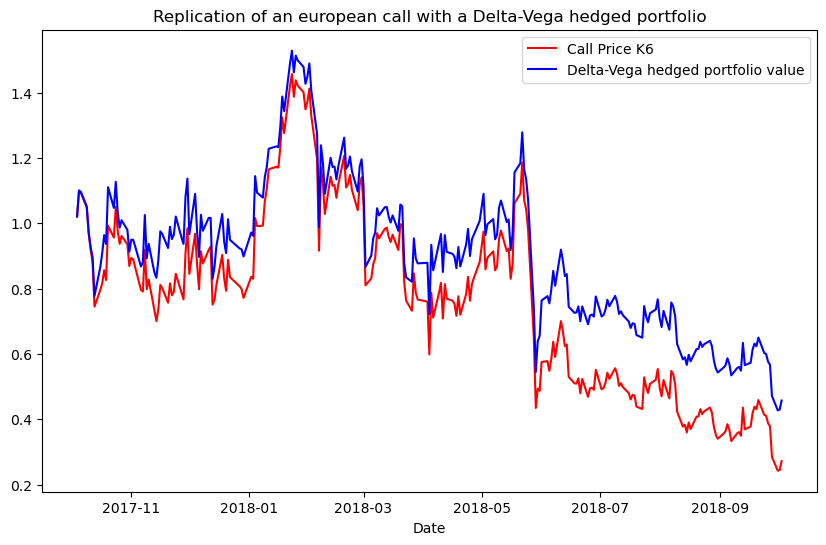

In [70]:
#Création du portefeuille delta-vega hedged
pft_dv_hedged=pd.DataFrame(index=data.index,columns=['Prix Call K6','Prix Call K6.5','Prix action','Quantite action','Quantite en Cbis','poche action','poche Cbis','poche ZC','Valeur pft','vega','vega bis'])

#Initialisation
K=6
Kbis=6.5
r=0
maturite = dt.datetime(2018,12,31)
nb_jours=maturite-pft_dv_hedged.index[0]
nombre_jours_par_an=365.25
Temps=nb_jours.days/nombre_jours_par_an

#First row of the dataframe
pft_dv_hedged.iloc[0]['Prix action']=data.iloc[0]['Prix action']
pft_dv_hedged.iloc[0]['Prix Call K6']=data.iloc[0]['Prix option strike 6']
pft_dv_hedged.iloc[0]['Prix Call K6.5']=data.iloc[0]['Prix option strike 6,5']
    
    #Calculation of the delta and vega for each european call
delta=BS_delta(pft_dv_hedged.iloc[0]['Prix action'],Temps,iv.iloc[0]['vol implicite option strike 6 Newton-Raphson'],K,r)
delta_bis=BS_delta(pft_dv_hedged.iloc[0]['Prix action'],Temps,iv.iloc[0]['vol implicite option strike 6.5 Newton-Raphson'],Kbis,r)
vega=BS_vega(pft_dv_hedged.iloc[0]['Prix action'],Temps,iv.iloc[0]['vol implicite option strike 6 Newton-Raphson'],K,r)
vega_bis=BS_vega(pft_dv_hedged.iloc[0]['Prix action'],Temps,iv.iloc[0]['vol implicite option strike 6.5 Newton-Raphson'],Kbis,r)

#Vega
pft_dv_hedged.iloc[0]['vega']=vega
pft_dv_hedged.iloc[0]['vega bis']=vega_bis

pft_dv_hedged.iloc[0]['Quantite en Cbis']=vega/vega_bis
pft_dv_hedged.iloc[0]['Quantite action']=delta-(delta_bis*(vega/vega_bis))
pft_dv_hedged.iloc[0]['poche action']=pft_dv_hedged.iloc[0]['Quantite action']*pft_dv_hedged.iloc[0]['Prix action']
pft_dv_hedged.iloc[0]['poche Cbis']=pft_dv_hedged.iloc[0]['Prix Call K6.5']*pft_dv_hedged.iloc[0]['Quantite en Cbis']
pft_dv_hedged.iloc[0]['Valeur pft']=pft_dv_hedged.iloc[0]['Prix Call K6']
pft_dv_hedged.iloc[0]['poche ZC']=pft_dv_hedged.iloc[0]['Valeur pft']-pft_dv_hedged.iloc[0]['poche action']-pft_dv_hedged.iloc[0]['poche Cbis']

#Recurrence
for i in range(1,len(pft_dv_hedged.index)):
    nb_jours=maturite-pft_dv_hedged.index[i]
    Temps=nb_jours.days/nombre_jours_par_an
    pft_dv_hedged.iloc[i]['Prix action']=data.iloc[i]['Prix action']
    pft_dv_hedged.iloc[i]['Prix Call K6']=data.iloc[i]['Prix option strike 6']
    pft_dv_hedged.iloc[i]['Prix Call K6.5']=data.iloc[i]['Prix option strike 6,5']

        #Calculation of the delta and vega for each european call
    delta=BS_delta(pft_dv_hedged.iloc[i]['Prix action'],Temps,iv.iloc[i]['vol implicite option strike 6 Newton-Raphson'],K,r)
    delta_bis=BS_delta(pft_dv_hedged.iloc[i]['Prix action'],Temps,iv.iloc[i]['vol implicite option strike 6.5 Newton-Raphson'],Kbis,r)
    vega=BS_vega(pft_dv_hedged.iloc[i]['Prix action'],Temps,iv.iloc[i]['vol implicite option strike 6 Newton-Raphson'],K,r)
    vega_bis=BS_vega(pft_dv_hedged.iloc[i]['Prix action'],Temps,iv.iloc[i]['vol implicite option strike 6.5 Newton-Raphson'],Kbis,r)
    vegaAB=(iv.iloc[i]['vol implicite option strike 6.5 Newton-Raphson']-iv.iloc[i-1]['vol implicite option strike 6.5 Newton-Raphson'])/(iv.iloc[i]['vol implicite option strike 6 Newton-Raphson']-iv.iloc[i-1]['vol implicite option strike 6 Newton-Raphson'])

        #Vega
    pft_dv_hedged.iloc[i]['vega']=vega
    pft_dv_hedged.iloc[i]['vega bis']=vega_bis
    
    pft_dv_hedged.iloc[i]['Quantite en Cbis']=vega/vega_bis
    pft_dv_hedged.iloc[i]['Quantite action']=delta-(delta_bis*(vega/vega_bis))
    pft_dv_hedged.iloc[i]['poche action']=pft_dv_hedged.iloc[i]['Quantite action']*pft_dv_hedged.iloc[i]['Prix action']
    pft_dv_hedged.iloc[i]['poche Cbis']=pft_dv_hedged.iloc[i]['Prix Call K6.5']*pft_dv_hedged.iloc[i]['Quantite en Cbis']
    pft_dv_hedged.iloc[i]['Valeur pft']=pft_dv_hedged.iloc[i-1]['Valeur pft']+ \
        pft_dv_hedged.iloc[i-1]['Quantite action']*(pft_dv_hedged.iloc[i]['Prix action']-pft_dv_hedged.iloc[i-1]['Prix action'])+\
        pft_dv_hedged.iloc[i-1]['Quantite en Cbis']*(pft_dv_hedged.iloc[i]['Prix Call K6.5']-pft_dv_hedged.iloc[i-1]['Prix Call K6.5'])
    pft_dv_hedged.iloc[i]['poche ZC']=pft_dv_hedged.iloc[i]['Valeur pft']-pft_dv_hedged.iloc[i]['poche action']-pft_dv_hedged.iloc[i]['poche Cbis']

plt.figure(2)
plt.figure(figsize=(10, 6)) 
plt.plot(pft_dv_hedged['Prix Call K6'],c='r')
plt.plot(pft_dv_hedged['Valeur pft'],c='b')
plt.xlabel('Date')
plt.legend(["Call Price K6","Delta-Vega hedged portfolio value"])
plt.title("Replication of an european call with a Delta-Vega hedged portfolio")
plt.show()

#### Calculation of the average difference between the K6 Call Price and the value of the dela-vega hedged portfolio

In [71]:
MAE_3 = np.mean(np.abs(pft_dv_hedged['Prix Call K6'] - pft_dv_hedged['Valeur pft']))
print(f"the average difference is : {round(MAE_3,4)}")

the average difference is : 0.1339
